Running Verification 4.1...


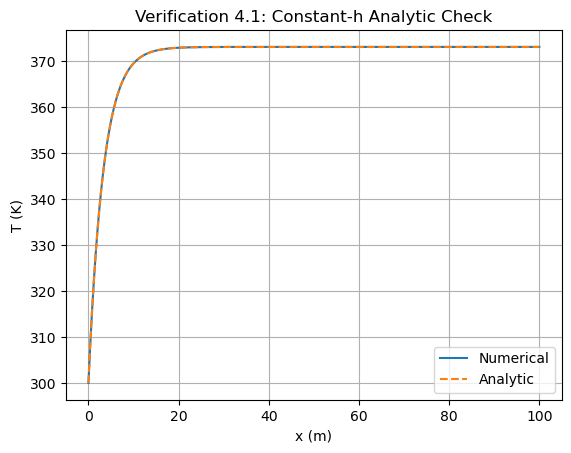

Running Verification 4.2...


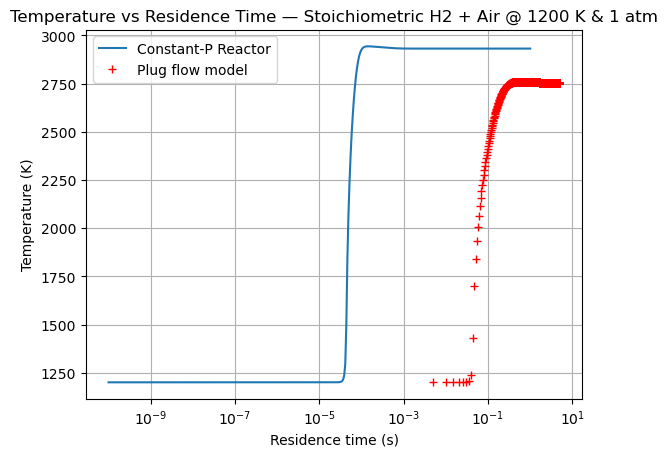

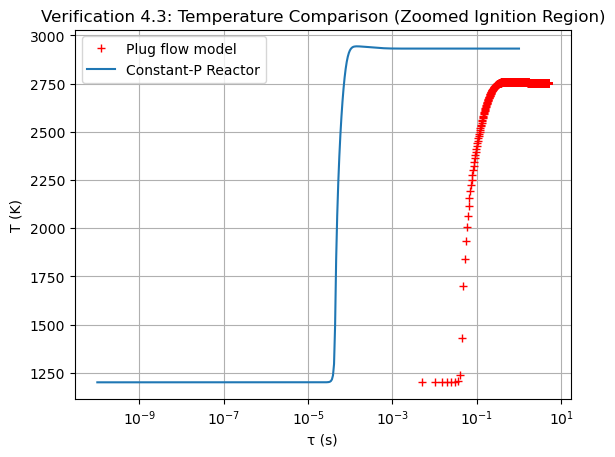

Parametric sweep: Wall Temperature


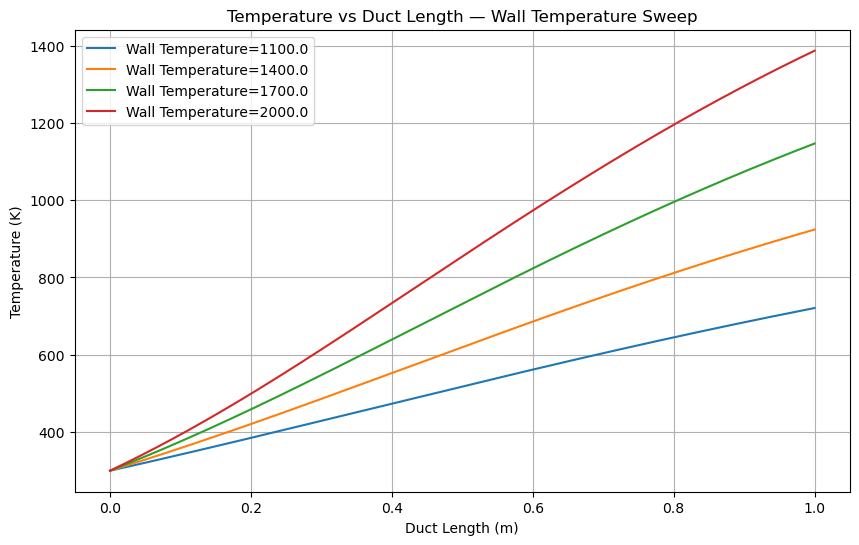

Parametric sweep: Velocity


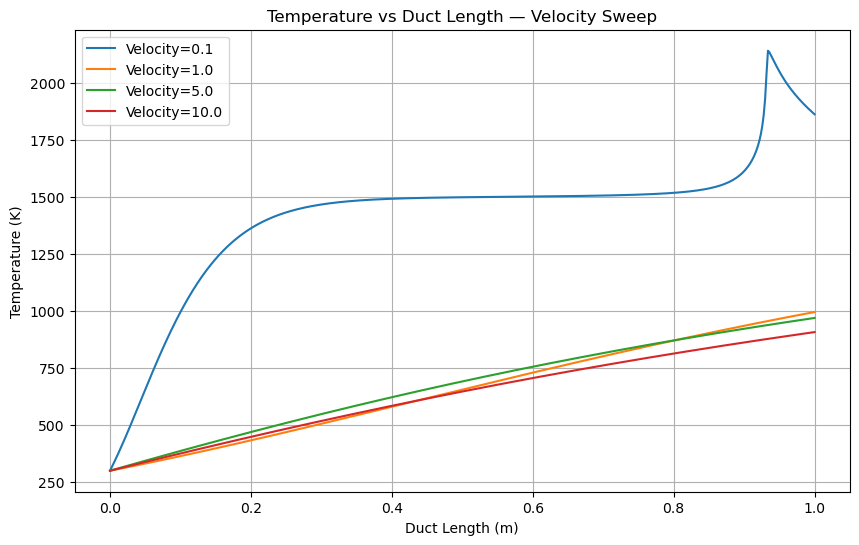

Parametric sweep: Diameter


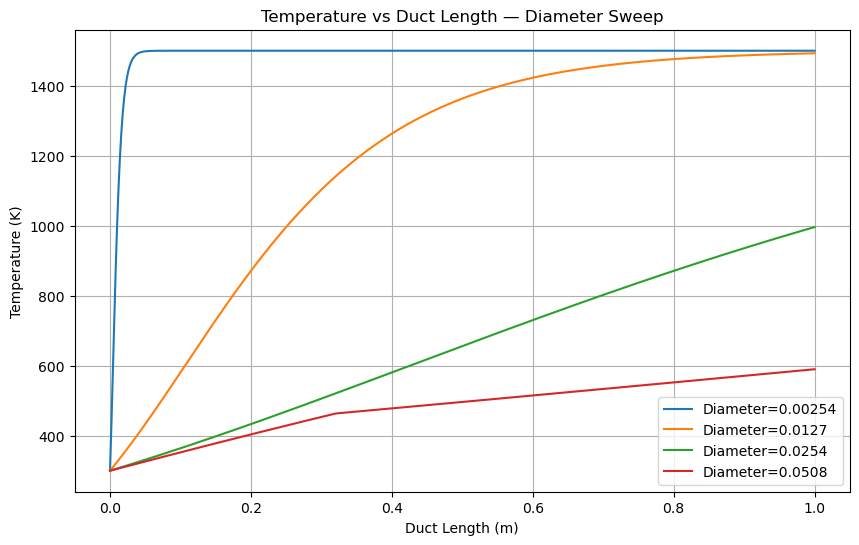

Parametric sweep: Wall Temperature


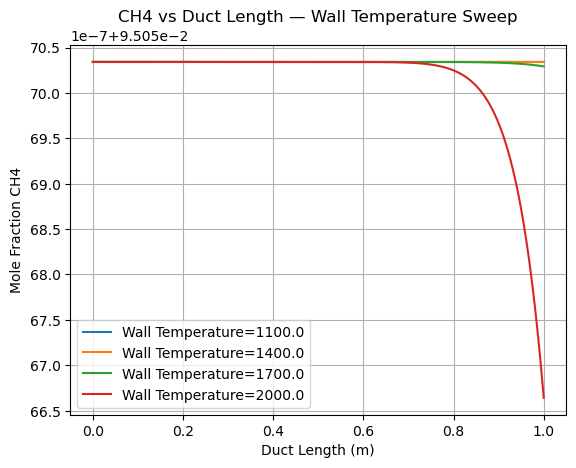

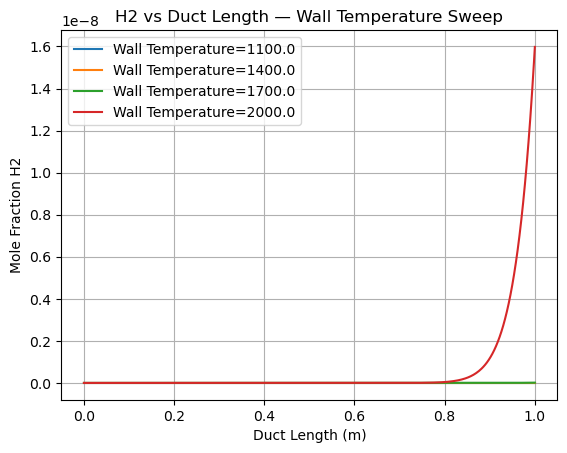

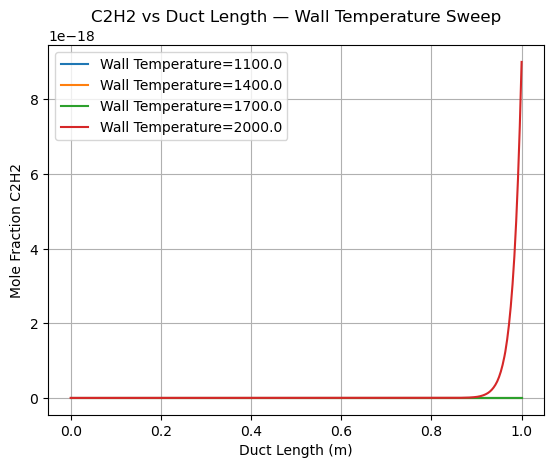

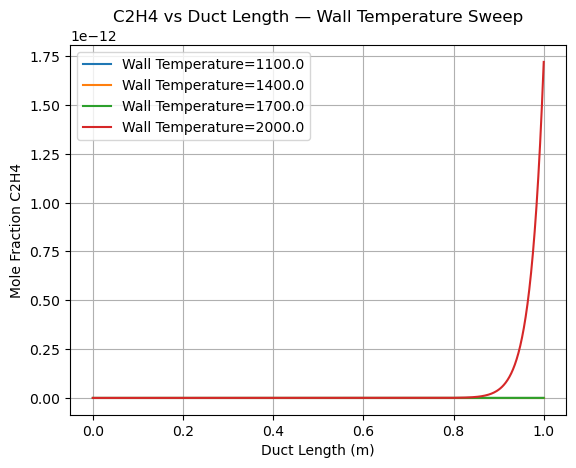

Parametric sweep: Velocity


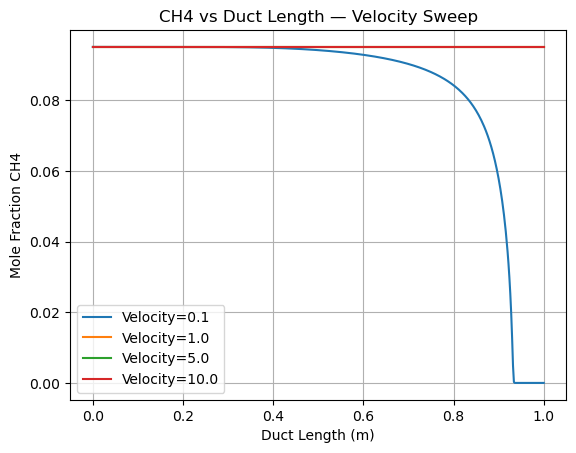

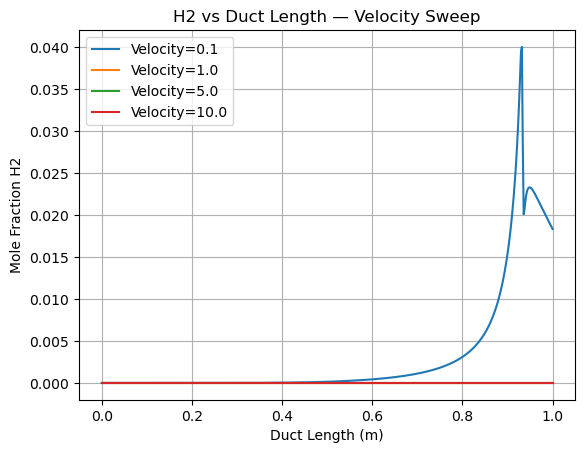

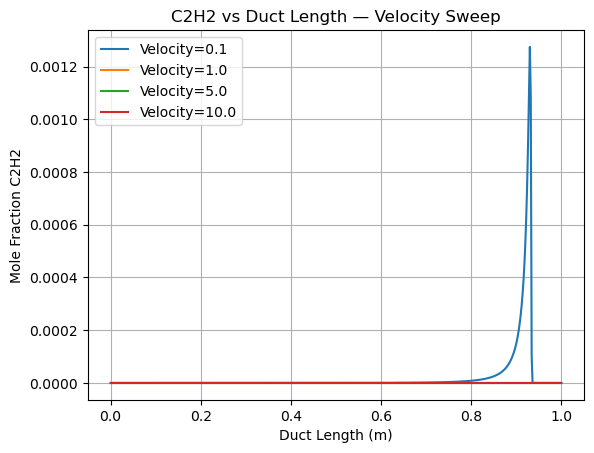

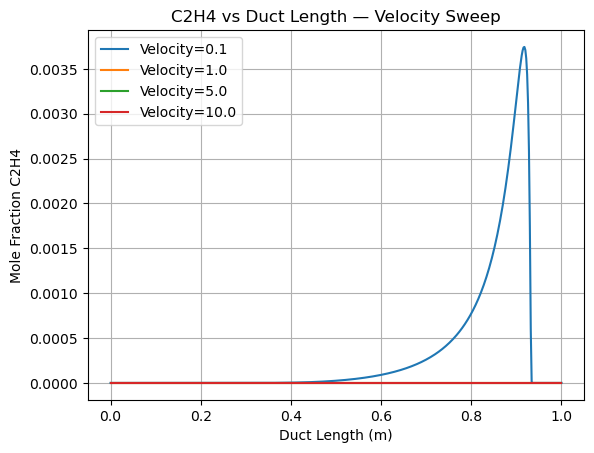

Parametric sweep: Diameter


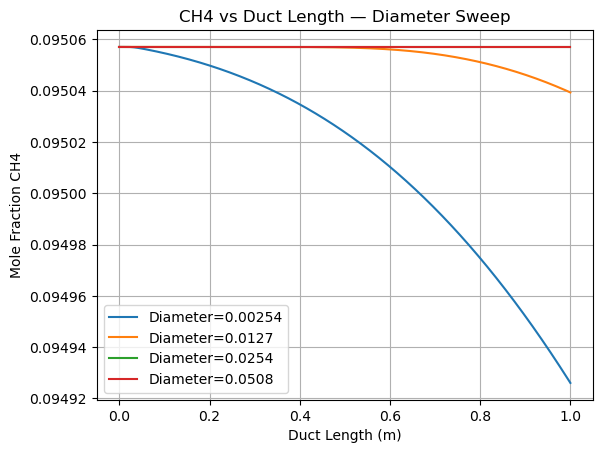

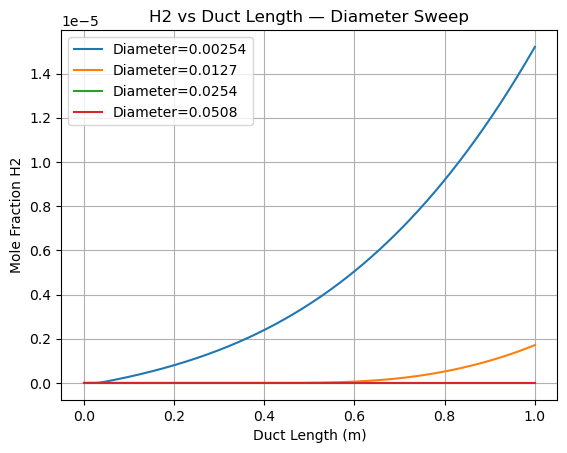

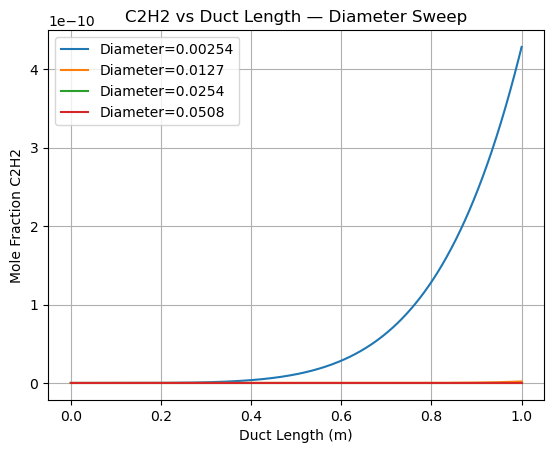

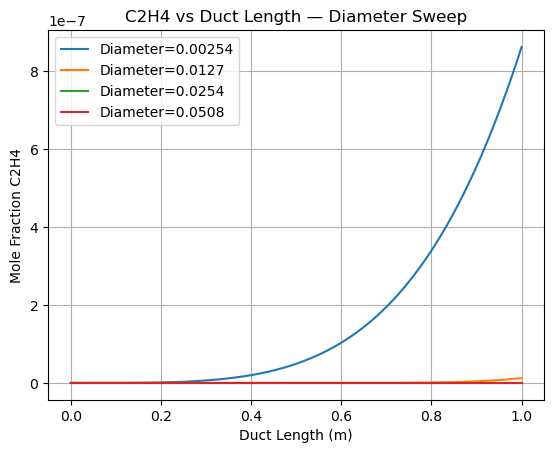

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import cantera as ct
from Project_3_4 import solve_pfr_cantera  # Make sure it's in the same folder

# =============================================================================
# Shared Parameters
# =============================================================================
D = 0.05  # 5 cm
x_end = 100.0  # 100 meters
Npts = 2000
p0 = ct.one_atm

# =============================================================================
# Verification 4.1 — Constant h, inert gas (analytic check)
# =============================================================================
print("Running Verification 4.1...")

def h_const(T, Y, p, rho, u):
    return 100.0  # W/m^2-K

def Tw_const(x):
    return 373.15  # 100°C wall temp

gas = ct.Solution('gri30.yaml')
X0 = {'AR': 1.0}
T0 = 300.0
gas.TPX = T0, p0, X0
mdot = 0.1  # kg/s

sol = solve_pfr_cantera(
    'gri30.yaml', X0, T0, p0, mdot, D, Tw_const, x_end,
    Npts=Npts, h_override=h_const
)

# Analytic Solution
h = 100
cp = gas.cp_mass
rho = gas.density
Per = np.pi * D
A = np.pi * D**2 / 4.0
u = mdot / (rho * A)
mcp = mdot * cp
T_analytic = Tw_const(0) + (T0 - Tw_const(0)) * np.exp(-h * Per * sol['x'] / mcp)

plt.figure()
plt.plot(sol["x"], sol["T"], label="Numerical")
plt.plot(sol["x"], T_analytic, "--", label="Analytic")
plt.xlabel("x (m)")
plt.ylabel("T (K)")
plt.title("Verification 4.1: Constant-h Analytic Check")
plt.legend()
plt.grid(True)
plt.show()

# =============================================================================
# Verification 4.2 — Reacting gas, no heat transfer (compare to Cantera reactor)
# =============================================================================
print("Running Verification 4.2...")

X0 = {'H2': 2.0, 'O2': 1.0, 'N2': 3.76}
T0 = 1200.0
gas = ct.Solution('gri30.yaml')
gas.TPX = T0, p0, X0
rho = gas.density
A = np.pi * D**2 / 4.0
u0 = 10.0  # m/s
mdot = rho * A * u0

sol_pfr = solve_pfr_cantera(
    'gri30.yaml', X0, T0, p0, mdot, D, 0.0, x_end, Npts=Npts,
    h_override=lambda T, Y, p, rho, u: 0.0
)

# Compute residence time from local velocity
tau = np.zeros_like(sol_pfr["x"])
for i in range(1, len(tau)):
    dx = sol_pfr["x"][i] - sol_pfr["x"][i-1]
    T_local = sol_pfr["T"][i]
    Y_local = sol_pfr["Y"][:, i]
    gas.TPY = T_local, p0, Y_local
    rho_local = gas.density
    u_local = mdot / (rho_local * A)
    tau[i] = tau[i-1] + dx / u_local

# Cantera constant-pressure, fixed-mass reactor
gas.TPX = T0, p0, X0
r = ct.IdealGasReactor(gas, energy='on')
sim = ct.ReactorNet([r])
times = np.logspace(-10, 0, 400)
T_reactor = []
tau_reactor = []

for t in times:
    sim.advance(t)
    T_reactor.append(r.T)
    tau_reactor.append(t)

plt.figure()
plt.plot(tau_reactor, T_reactor, label="Constant-P Reactor")
plt.plot(tau, sol_pfr["T"], "r+", label="Plug flow model")
plt.xlabel("Residence time (s)")
plt.ylabel("Temperature (K)")
plt.title("Temperature vs Residence Time — Stoichiometric H2 + Air @ 1200 K & 1 atm")
plt.xscale("log")
plt.legend()
plt.grid(True)
plt.show()

# =============================================================================
# Verification 4.3 — Zoomed in on ignition region (log x-scale)
# =============================================================================
plt.figure()
plt.plot(tau, sol_pfr["T"], "r+", label="Plug flow model")
plt.plot(tau_reactor, T_reactor, label="Constant-P Reactor")
plt.xscale("log")

plt.xlabel("τ (s)")
plt.ylabel("T (K)")
plt.title("Verification 4.3: Temperature Comparison (Zoomed Ignition Region)")
plt.legend()
plt.grid(True)
plt.show()

# =============================================================================
# Parametric Sweep — Wall Temperature, Velocity, and Diameter
# =============================================================================
import numpy as np
import matplotlib.pyplot as plt
from Project_3_4 import solve_pfr_cantera
import cantera as ct

# Nominal conditions
Tw_nom = 1500.0        # K
u_nom = 1.0            # m/s
D_nom = 1.0 * 0.0254   # 1 inch in meters

X0 = {'CH4': 1.0, 'O2': 2.0, 'N2': 7.52}  # methane-air stoichiometry
T0 = 300.0
p0 = ct.one_atm
x_end = 1.0  # meters
Npts = 500

# Ranges for parametric sweeps
Tw_values = np.linspace(1100, 2000, 4)  # K
u_values = np.array([0.1, 1.0, 5.0, 10.0])  # m/s
D_values = np.array([0.1, 0.5, 1.0, 2.0]) * 0.0254  # in meters

sweep_cases = {
    "Wall Temperature": Tw_values,
    "Velocity": u_values,
    "Diameter": D_values
}

# Function to compute heat input and efficiency
def compute_heat_efficiency(sol, Tw_func, D, mdot):
    gas = ct.Solution('gri30.yaml')
    A = np.pi * D**2 / 4.0
    Per = np.pi * D
    h = 100.0  # approximate heat transfer coefficient (or use h_conv)
    
    Q_dot = np.zeros_like(sol["x"])
    for i, x in enumerate(sol["x"]):
        T = sol["T"][i]
        Tw_val = Tw_func(x) if callable(Tw_func) else Tw_func
        Q_dot[i] = h * Per * (Tw_val - T)  # W/m along the duct

    # Efficiency: fraction of fuel energy absorbed by gas
    gas.TPX = sol["T"][0], p0, sol["Y"][:,0]
    H0 = gas.enthalpy_mass
    H_end = np.zeros_like(sol["T"])
    for i in range(len(sol["T"])):
        gas.TPY = sol["T"][i], p0, sol["Y"][:,i]
        H_end[i] = gas.enthalpy_mass

    efficiency = (H_end - H0) / (H_end.max() - H0)  # normalized 0-1
    return Q_dot, efficiency

# Loop over sweep types
for sweep_name, sweep_values in sweep_cases.items():
    plt.figure(figsize=(10,6))
    print(f"Parametric sweep: {sweep_name}")

    for val in sweep_values:
        # Set parameters for this iteration
        Tw = Tw_nom
        u = u_nom
        D = D_nom

        if sweep_name == "Wall Temperature":
            Tw = val
        elif sweep_name == "Velocity":
            u = val
        elif sweep_name == "Diameter":
            D = val

        # Compute mass flow
        gas = ct.Solution('gri30.yaml')
        gas.TPX = T0, p0, X0
        A = np.pi * D**2 / 4.0
        rho = gas.density
        mdot = rho * A * u

        # Wall temperature function
        Tw_func = lambda x: Tw

        # Solve PFR
        sol = solve_pfr_cantera('gri30.yaml', X0, T0, p0, mdot, D, Tw_func, x_end, Npts=Npts)

        # Compute residence time
        tau = np.zeros_like(sol["x"])
        for i in range(1, len(tau)):
            dx = sol["x"][i] - sol["x"][i-1]
            T_local = sol["T"][i]
            Y_local = sol["Y"][:, i]
            gas.TPY = T_local, p0, Y_local
            rho_local = gas.density
            u_local = mdot / (rho_local * A)
            tau[i] = tau[i-1] + dx / u_local

        # Compute heat input and efficiency
        Q_dot, efficiency = compute_heat_efficiency(sol, Tw_func, D, mdot)

        # Plot results
        plt.plot(sol["x"], sol["T"], label=f"{sweep_name}={val}")
    plt.xlabel("Duct Length (m)")
    plt.ylabel("Temperature (K)")
    plt.title(f"Temperature vs Duct Length — {sweep_name} Sweep")
    plt.legend()
    plt.grid(True)
    plt.show()

# Additional plots for mole fractions and efficiency
species_to_plot = ["CH4", "H2", "C2H2", "C2H4"]

for sweep_name, sweep_values in sweep_cases.items():
    print(f"Parametric sweep: {sweep_name}")
    results = {}  # store solutions for each sweep value

    for val in sweep_values:
        # Set parameters for this iteration
        Tw = Tw_nom
        u = u_nom
        D = D_nom

        if sweep_name == "Wall Temperature":
            Tw = val
        elif sweep_name == "Velocity":
            u = val
        elif sweep_name == "Diameter":
            D = val

        # Compute mass flow
        gas = ct.Solution('gri30.yaml')
        gas.TPX = T0, p0, X0
        A = np.pi * D**2 / 4.0
        rho = gas.density
        mdot = rho * A * u

        Tw_func = lambda x: Tw

        sol = solve_pfr_cantera('gri30.yaml', X0, T0, p0, mdot, D, Tw_func, x_end, Npts=Npts)

        # Store the solution
        results[val] = sol

    # Now plot species mole fractions
    for sp in species_to_plot:
        plt.figure()
        for val in sweep_values:
            sol = results[val]
            gas.TPY = sol["T"][0], p0, sol["Y"][:, 0]  # initialize gas
            idx = gas.species_index(sp)
            plt.plot(sol["x"], sol["X"][idx, :], label=f"{sweep_name}={val}")
        plt.xlabel("Duct Length (m)")
        plt.ylabel(f"Mole Fraction {sp}")
        plt.title(f"{sp} vs Duct Length — {sweep_name} Sweep")
        plt.legend()
        plt.grid(True)
        plt.show()


